<a href="https://colab.research.google.com/github/CalumGabbutt/CCMI-CWIG-Bayes/blob/main/2_NPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting simulation-based models to data using neural networks

In this tutorial, we will use the Python SBI package (https://sbi-dev.github.io/sbi/latest) to showcase how to fit a simulation-based model to data. The model is a stochastic version of how stem cell dynamics pattern methylation data, described here: https://doi.org/10.1038/s41587-021-01109-w


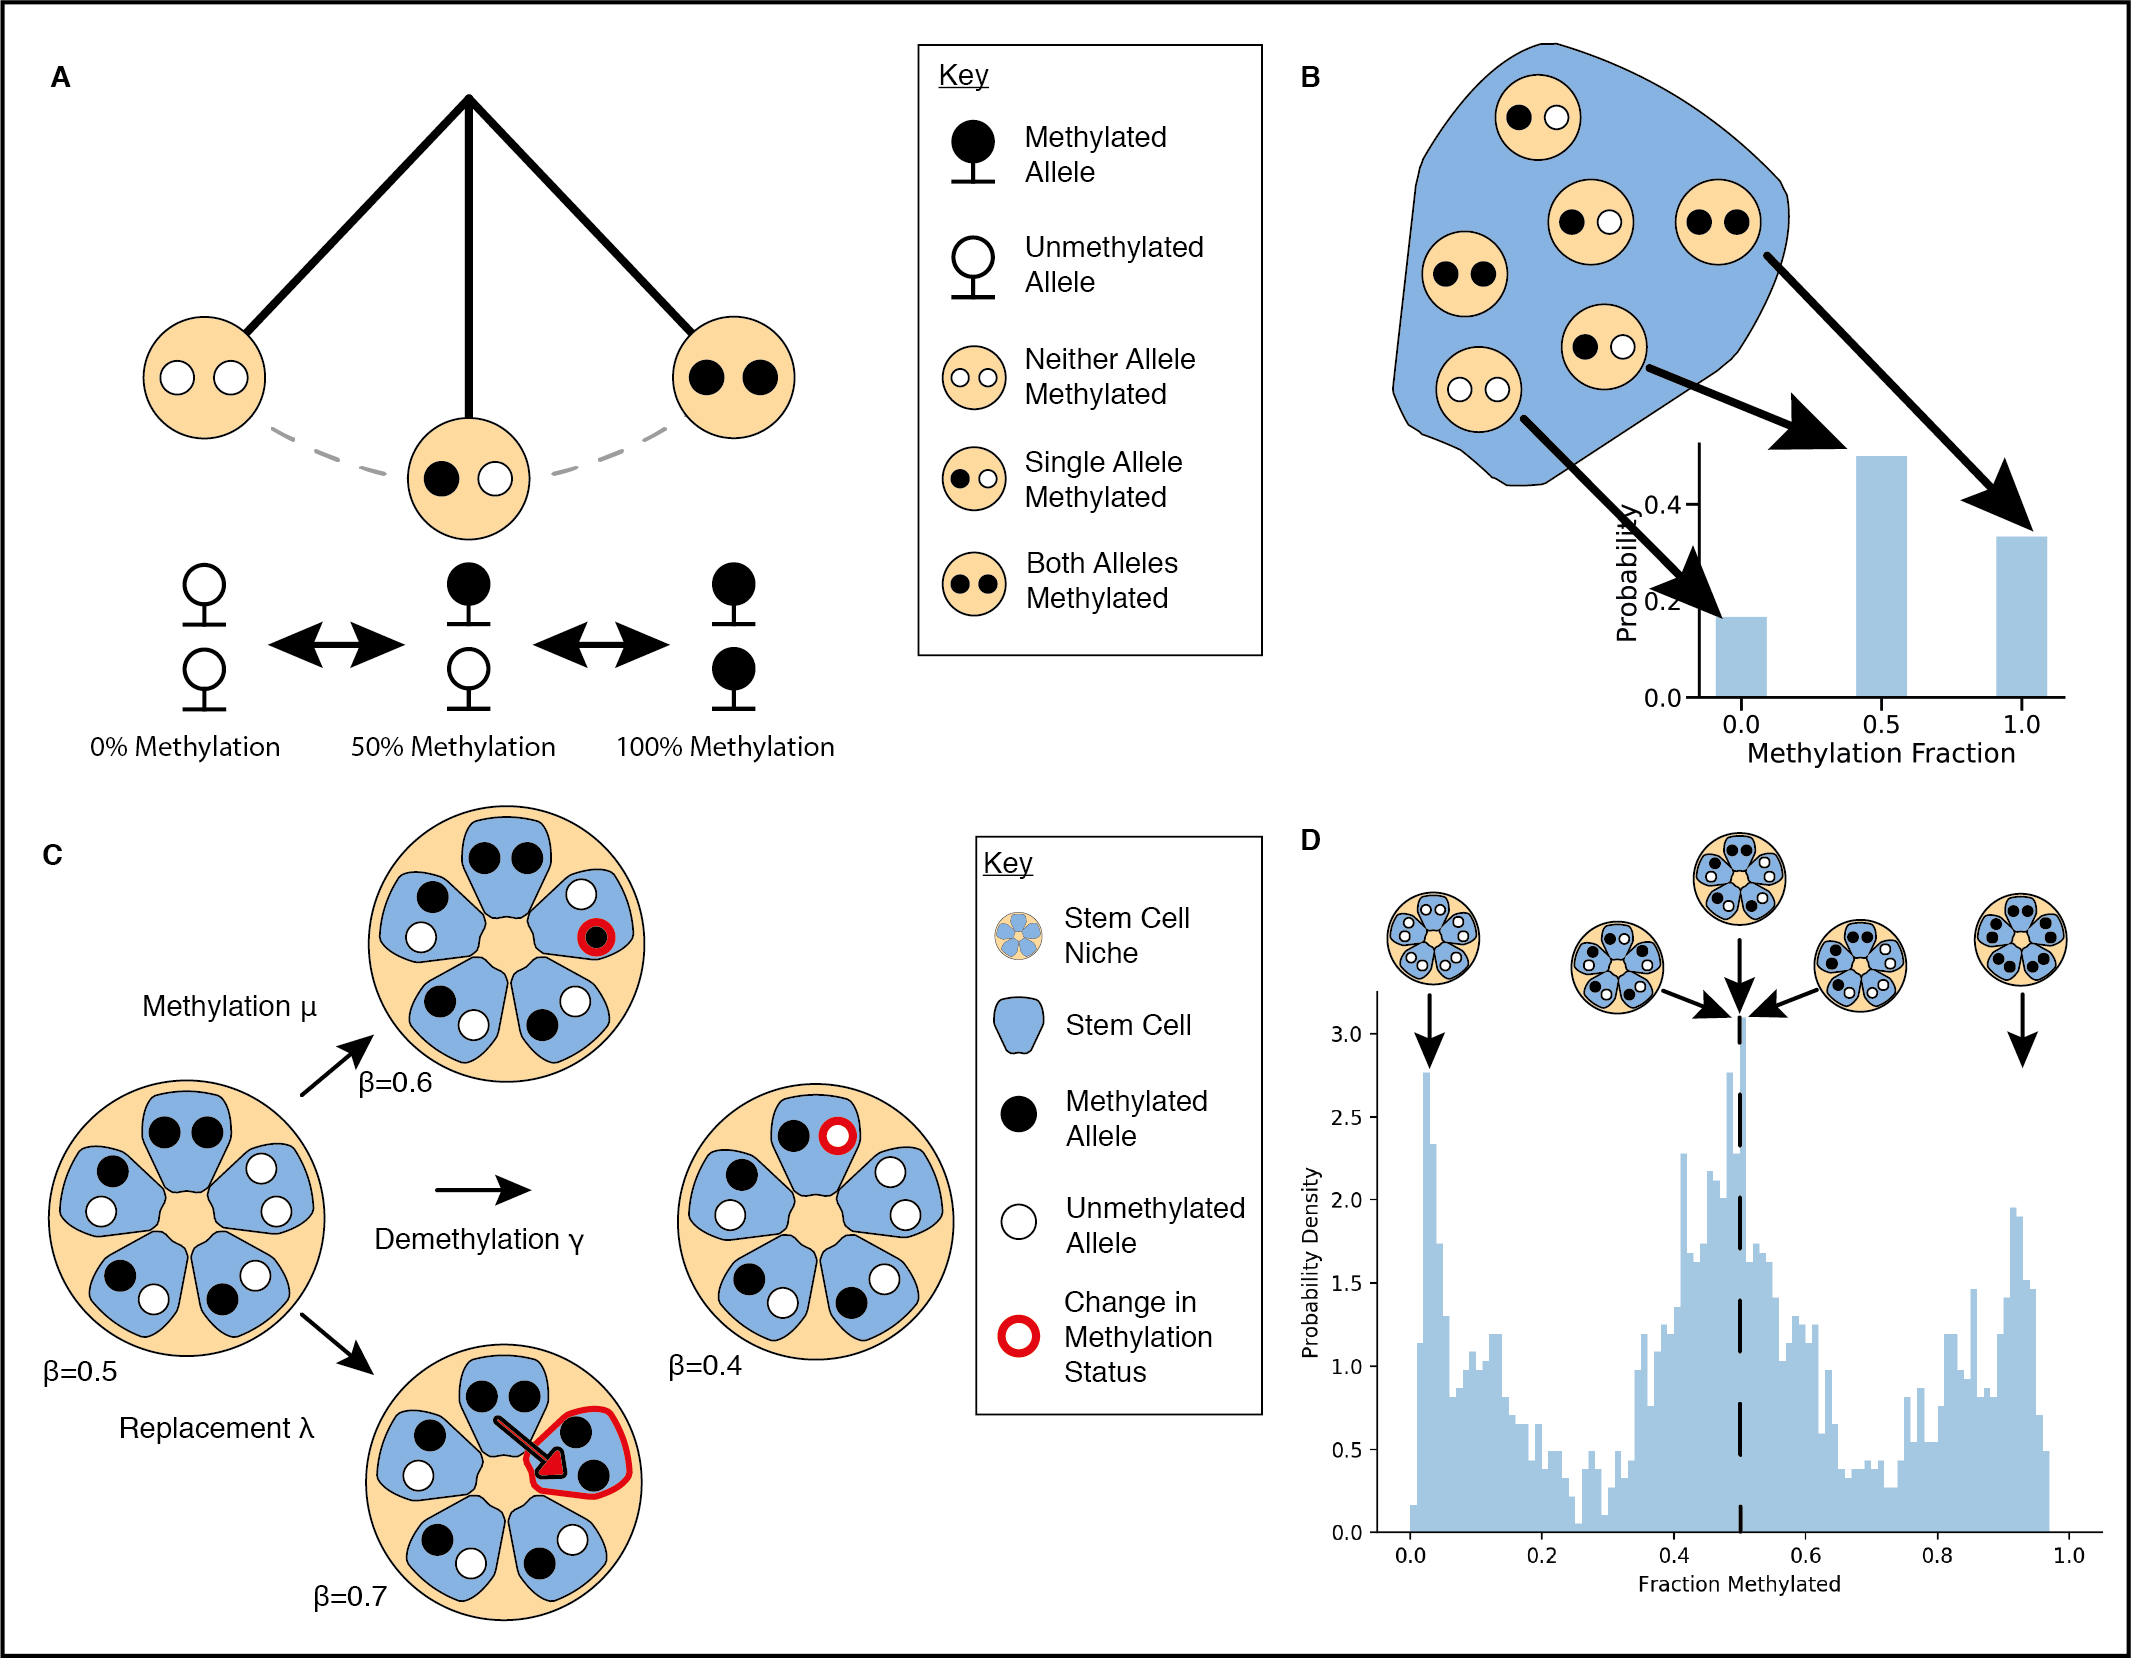

This install cell can take a while, depending on download speeds. Because our networks are generally shallow and not-tall, we don't expect a speed up by running on a GPU, so you can keep the default runtime type as CPU.

In [6]:
!pip install sbi
!pip install corner

In [7]:
import random
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib
import seaborn as sns
from scipy import stats
import corner
import os
import pickle

import torch
from torch.distributions import (
    Beta,
    LogNormal,
    HalfNormal,
    Uniform,
    TransformedDistribution,
    Categorical)
from torch.distributions.transforms import AffineTransform

from sbi.analysis import pairplot, conditional_potential
from sbi.inference import (
    NPE,
    simulate_for_sbi,
    MCMCPosterior,
    posterior_estimator_based_potential)
from sbi.utils import MultipleIndependent
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

The biological system we will be modelling is that of the stem cells that lie at the base of each colonic crypt (test-tube shaped structures that make up the large intestine). Previous work in mouse has shown that each crypt consists of a small number of stem cells which are able to divide and displace (i.e. replace) the other stem cells over time.

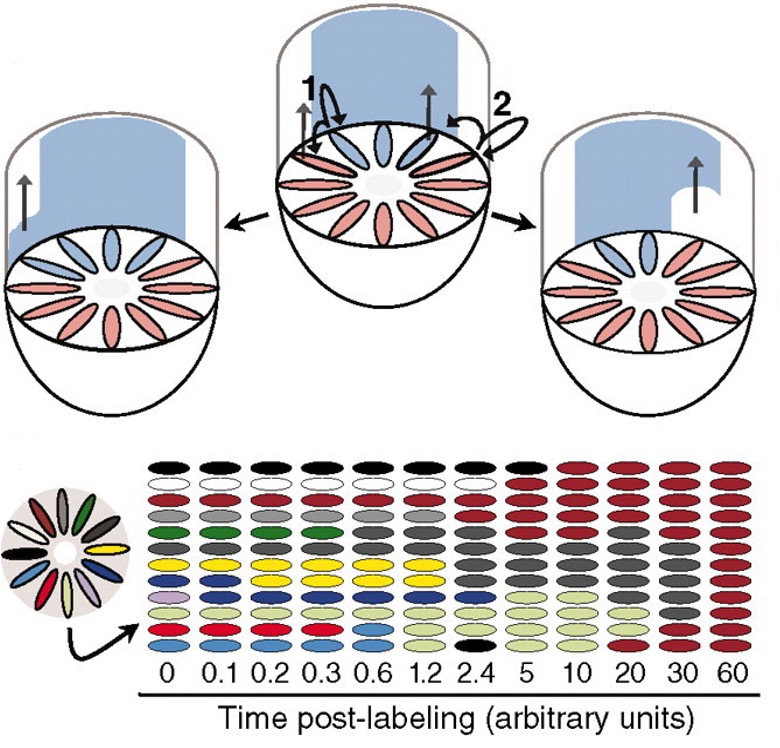

In mouse, this means each crypt stochastically but inevitably ends up being dominated by the descendents of just 1 stem cell after ~1 month. However, in human it was unclear how many stem cells existed per crypt, and how often they replaced each other. In our work, we used a system of ODEs to model how naturally occurring changes in DNA methylation varied as a function of the stem cell dynamics. This allowed us to compute a likelihood, so we could apply traditional Bayesian methods to learn these parameters for an individual crypt. Here, we are going to use a stochastic simulator and neural networks as an alternative approach.

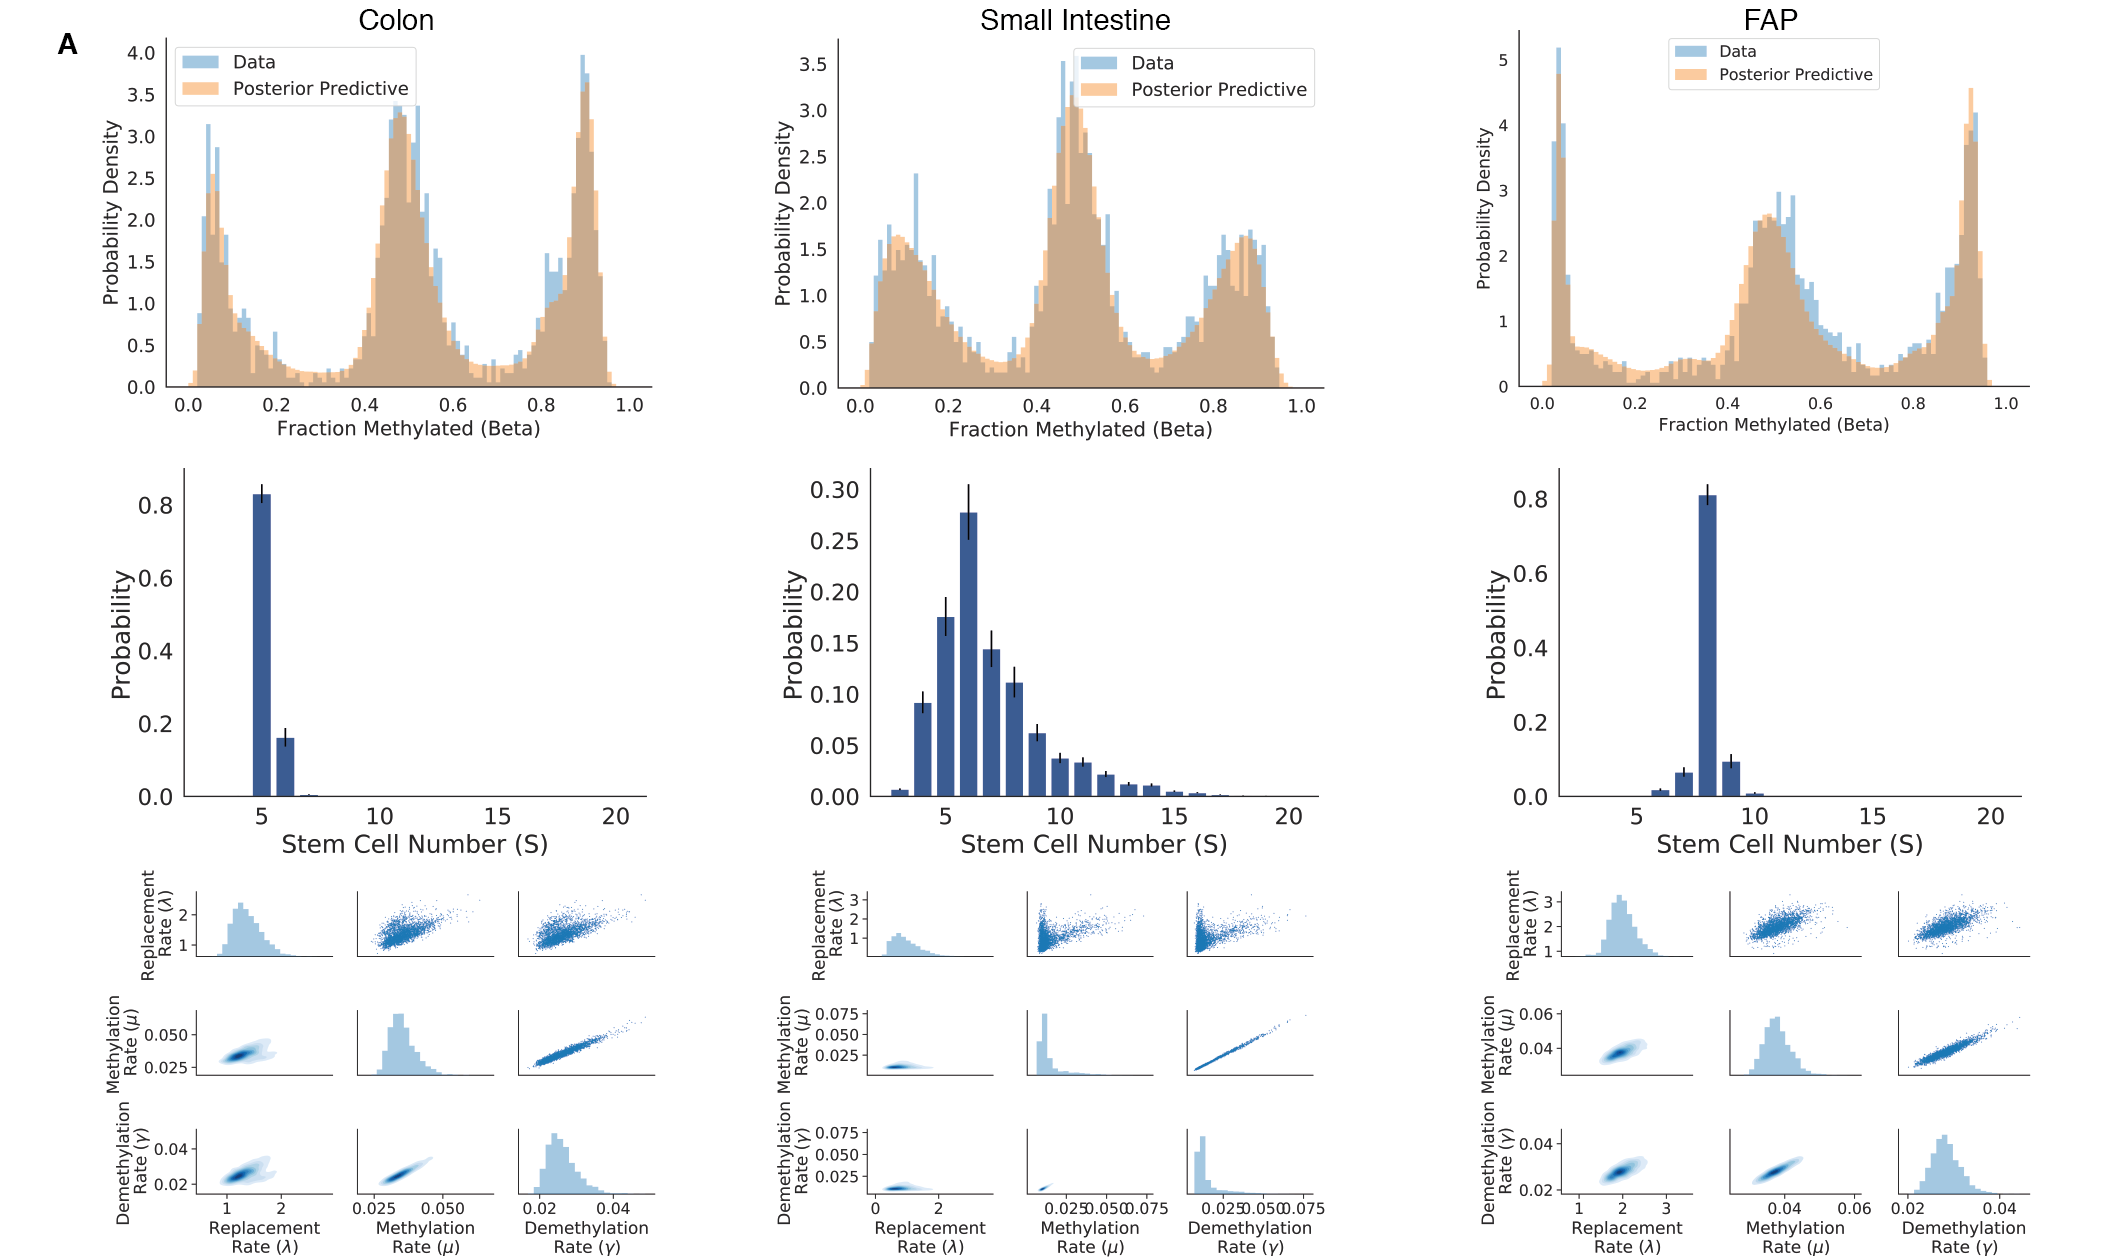

First, let's define the simulator functions to model how the distribution of fCpG methylation within a colonic crypt varies as a function of the replacement rate ( λ ), the epigenetic switching rates ( μ : forward,  𝛾 : backwards) and the parameters determining the noise in the array ( 𝛿 : offset from 0,  𝜂 : offset from 1,  𝜅 : precision of the array).

Notice how the simulation mostly relies on numpy arrays and functions, rather than torch ones. This is a nice feature of the SBI package, in that the simulation function can be written however you like, even in another programming language like Julia or C++, as long as they store simulation outputs in a format that can be read from Python.

In [8]:
def initialise_stemcell_niche(S, N):
    """
    Initialises the stemcell niche as a clonal population of S stem cells
    at N fCpGs. The poopulation is assumed to be homozygous methylated or
    demethylated at t=0

    Arguments:
        S: Number of stem cells in the niche - int >= 1
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A 3D  numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA allele and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Generate a random methylation pattern
    rng = np.random.default_rng()
    allele = rng.choice([True, False], size=N)

    # Create a 3D array representing the stemcell niche,
    dna = [copy.deepcopy(allele) for i in range(2)]
    dna = np.stack(dna)
    stemcells = np.stack([copy.deepcopy(dna) for i in range(S)])

    return stemcells

def select_adjacent_cells(S):
    """
    Randomly selects 2 adjacent cell indices, imposing periodic boundary
    conditions

    Arguments:
        S: Number of stem cells in the niche - int >= 1
    Returns:
        cells: Pair of randomly selected adjacent indices - tuple(int,int)
    """

    rng = np.random.default_rng()

    # Select the first cell at random, then pick an adjacent cell at random
    cell1 = rng.integers(S)
    cell2 = rng.choice([(cell1 - 1) % S, (cell1 + 1) % S])

    cells = (cell1, cell2)

    return cells

def methylation_sim(lam, mu, gamma, S, age, N):
    """
    Simulates the evolution of fCpG methylation in a well-mixed population of
    stem cells

    Arguments:
        lam: Replacement rate of one stem cell by another (/year) - float > 0
        mu: Methylation rate (/year/allele) - float >= 0
        gamma: Methylation rate (/year/allele) - float >= 0
        S: Number of stem cells in the niche - int >= 1
        age: Length of time to simulate the process for (years) - float > 0
        N: Number of fCpGs to consider - int >= 1
    Returns:
        stemcells: A binary 3D numpy array representing the stemcell niche,
                    where the first index determines the cell, the second
                    index determines the DNA strand and the third index
                    determines the CpG site - np.array[:,:,:]
    """

    # Intialise the stemcell niche
    stemcells = initialise_stemcell_niche(S, N)

    rng = np.random.default_rng()

    # Use a Gillepsie algorithm to model individual CpG changing methylation
    # status and the stem cells replacing each other
    t = 0
    counter = 0
    while t < age:
        # Draw the time until the next replacement event, assuming the
        # replacements are Poisson distributed
        twait = 1 / (lam * S) * np.log(1 / random.random())

        if t + twait < age:

            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)

            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            # Now that we have taken care of any mutations that have occured,
            # pick 2 cells at random, one to replace the other
            cells = select_adjacent_cells(S)
            stemcells[cells[0]] = copy.deepcopy(stemcells[cells[1]])

            counter += 1

        else:
            twait = age - t
            t += twait

            # Count the number of methylated/non-methylated sites
            num_on = np.count_nonzero(stemcells)
            num_off = 2*N*S - num_on

            # Create a copy of the stemcells array to act as a mask
            boolean_mask = copy.deepcopy(stemcells)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was methylated at time t
            p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
            # For each site methylated at time t, draw from a random distribution
            # with the above probability to see whether it is still methylated
            stemcells[boolean_mask] = rng.binomial(1, p_given_on, num_on)

            # Calculate the probability that a site is methylated at time (t+twait),
            # given that the site was not methylated at time t
            p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))

            # For each site unmethylated at time t, draw from a random distribution
            # with the above probability to see whether it is methylated
            stemcells[~boolean_mask] = rng.binomial(1, p_given_off, num_off)

            break

    return stemcells

def beta_convert_params(mean, kappa):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution

    """

    if torch.is_tensor(kappa):
      if torch.any(kappa <= 0):
          raise Exception("kappa must be greater than 0")
    else:
      if np.any(kappa <= 0):
          raise Exception("kappa must be greater than 0")

    if torch.is_tensor(mean):
      if torch.any(mean <= 0) or torch.any(mean >= 1):
          raise Exception("mu must be between 0 and 1")
    else:
      if np.any(mean <= 0) or np.any(mean >= 1):
          raise Exception("mu must be between 0 and 1")

    a = kappa * mean
    b = kappa * (1- mean)

    return a, b

def beta_rvs(mean, kappa, **kwargs):
    """
    Convert mean/dispersion parameterization of a beta distribution to the ones
    scipy supports

    Arguments:
        mean: Mean of the beta distribution - 0 < float < 1
        kappa: Precision of the beta distribution - float > 0

    Returns:
        a, b: Standard parameterisation of the beta distibution
    """

    a, b = beta_convert_params(mean, kappa)

    return stats.beta.rvs(a, b, **kwargs)

def generate_data(S, lam, mu, gamma, delta, eta, kappa, age, N):

    stemcells = methylation_sim(lam, mu, gamma, S, age, N)

    mean_beta = np.mean(np.mean(stemcells, axis = 0), axis = 0)

    beta_obs = beta_rvs((eta - delta) * mean_beta + delta, kappa)

    return beta_obs

def lognormal_convert_params(mean, sigma):
    """
    Convert mean/std parameterization of a beta distribution to the ones
    scipy supports
    """

    if np.any(mean <= 0):
        raise Exception("mean must be greater than 0")
    elif np.any(sigma <= 0) :
        raise Exception("sigma must be greater than 0")

    log_mean = np.log(mean) - 0.5 * np.log1p(sigma**2 / mean**2)
    log_std = np.sqrt(np.log1p(sigma**2 / mean ** 2))

    return log_mean, log_std

Because the number of stem cells is a discrete parameter, we will have to be a bit careful about how we define constructing a density for it, so for our first pass, let's fix the number of stem cells, patient age and the number of fCpGs.

In [9]:
S = 5
N = 2000
age = 30

def prior_func():
    # Define independent prior for parameters [lam, mu, gamma,
    #            delta, eta, kappa]
    kappamean, kappastd = lognormal_convert_params(100, 30)

    prior = MultipleIndependent(
        [
            HalfNormal(torch.tensor([1.0])),
            HalfNormal(torch.tensor([0.05])),
            HalfNormal(torch.tensor([0.05])),
            Beta(torch.tensor([5.0]), torch.tensor([95.0])),
            Beta(torch.tensor([95.0]), torch.tensor([5.0])),
            LogNormal(torch.tensor([kappamean]), torch.tensor([kappastd])),
        ],
        validate_args=False,
    )

    return prior

def generate_data_wrapper(params):
    lam, mu, gamma, delta, eta, kappa = params
    return generate_data(S, lam, mu, gamma, delta, eta, kappa, age, N)

def calculate_summary_statistics(obs):
    hist, bin_edges = np.histogram(obs, np.linspace(0, 1, 101))
    return hist / np.sum(hist)

def simulation_wrapper(params):
    """
    Returns summary statistics from input paramaters in `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    # print(params)
    obs = generate_data_wrapper(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))

    return summstats

# Check prior, return PyTorch prior.
prior, num_parameters, prior_returns_numpy = process_prior(prior_func())

# Check simulator, returns PyTorch simulator able to simulate batches.
simulation_wrapper = process_simulator(simulation_wrapper, prior, prior_returns_numpy)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulation_wrapper, prior)

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

With our simulator defined, let's play around with the parameters and see how the distribution of fCpGs vary.

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

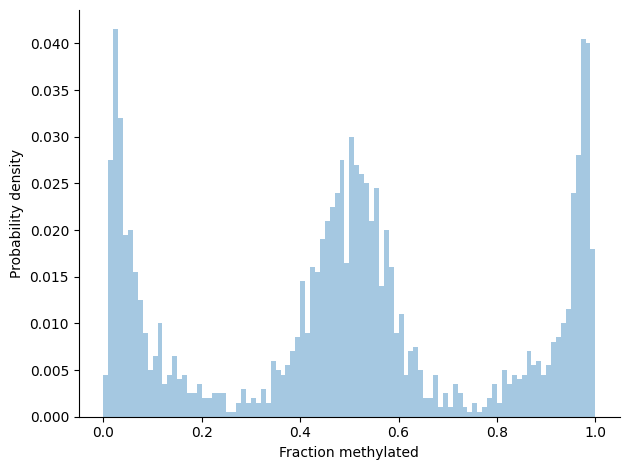

In [10]:
params_true = pd.Series({
    'lam' : 1.3,
    'mu' : 0.03,
    'gamma' : 0.03,
    'delta' : 0.04,
    'eta' : 0.97,
    'kappa' : 80,
})

# Let's generate and plot our "observed" data, y
y = simulation_wrapper(params_true.to_numpy().reshape(1, -1))
bins = np.linspace(0, 1, 101)
bin_centres = bins[:-1] + (bins[1:] - bins[:-1]) / 2

fig, ax = plt.subplots()
plt.bar(bin_centres, y[0, :],
        width=0.01, alpha = 0.4,
        )
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

Let's use the sbi simulate_for_sbi() function to generate a small test set of simulations and plot some of the samples.

In [11]:
param_test, x_test = simulate_for_sbi(simulation_wrapper, proposal=prior,
                                      num_simulations=1000)
print("theta.shape", param_test.shape)
print("x.shape", x_test.shape)

  0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

theta.shape torch.Size([1000, 6])
x.shape torch.Size([1000, 100])


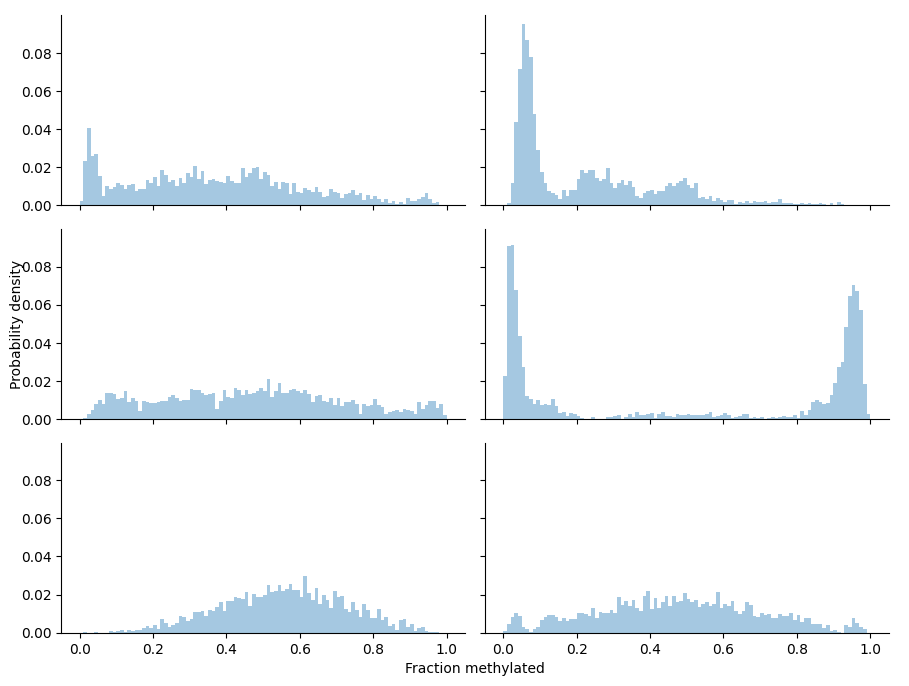

In [12]:
bins = np.linspace(0, 1, 101)

fig, axes = plt.subplots(3, 2, sharex = True, sharey = True,
                         figsize = (9.6, 7.2))
for i, ax in enumerate(axes.flatten()):
    ax.bar(bin_centres, x_test[i, :], width=0.01, alpha = 0.4)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False,
                left=False, right=False)
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')

sns.despine()
plt.tight_layout()

Now we have a simulator with a set of simulated data, paired with the parameters used to generate those simulations. Let's feed those to the default Neural Posterior Estimation (NPE) method.

In [13]:
inference = NPE(prior=prior)
inference.append_simulations(param_test, x_test)

In [14]:
density_estimator = inference.train()
posterior = inference.build_posterior()

 Neural network successfully converged after 75 epochs.

We now have an amortised posterior object which will rapidly return samples from the posterior given any set of observed data. Let's pass it the observed data y above and examine the posterior.

  0%|          | 0/1000 [00:00<?, ?it/s]

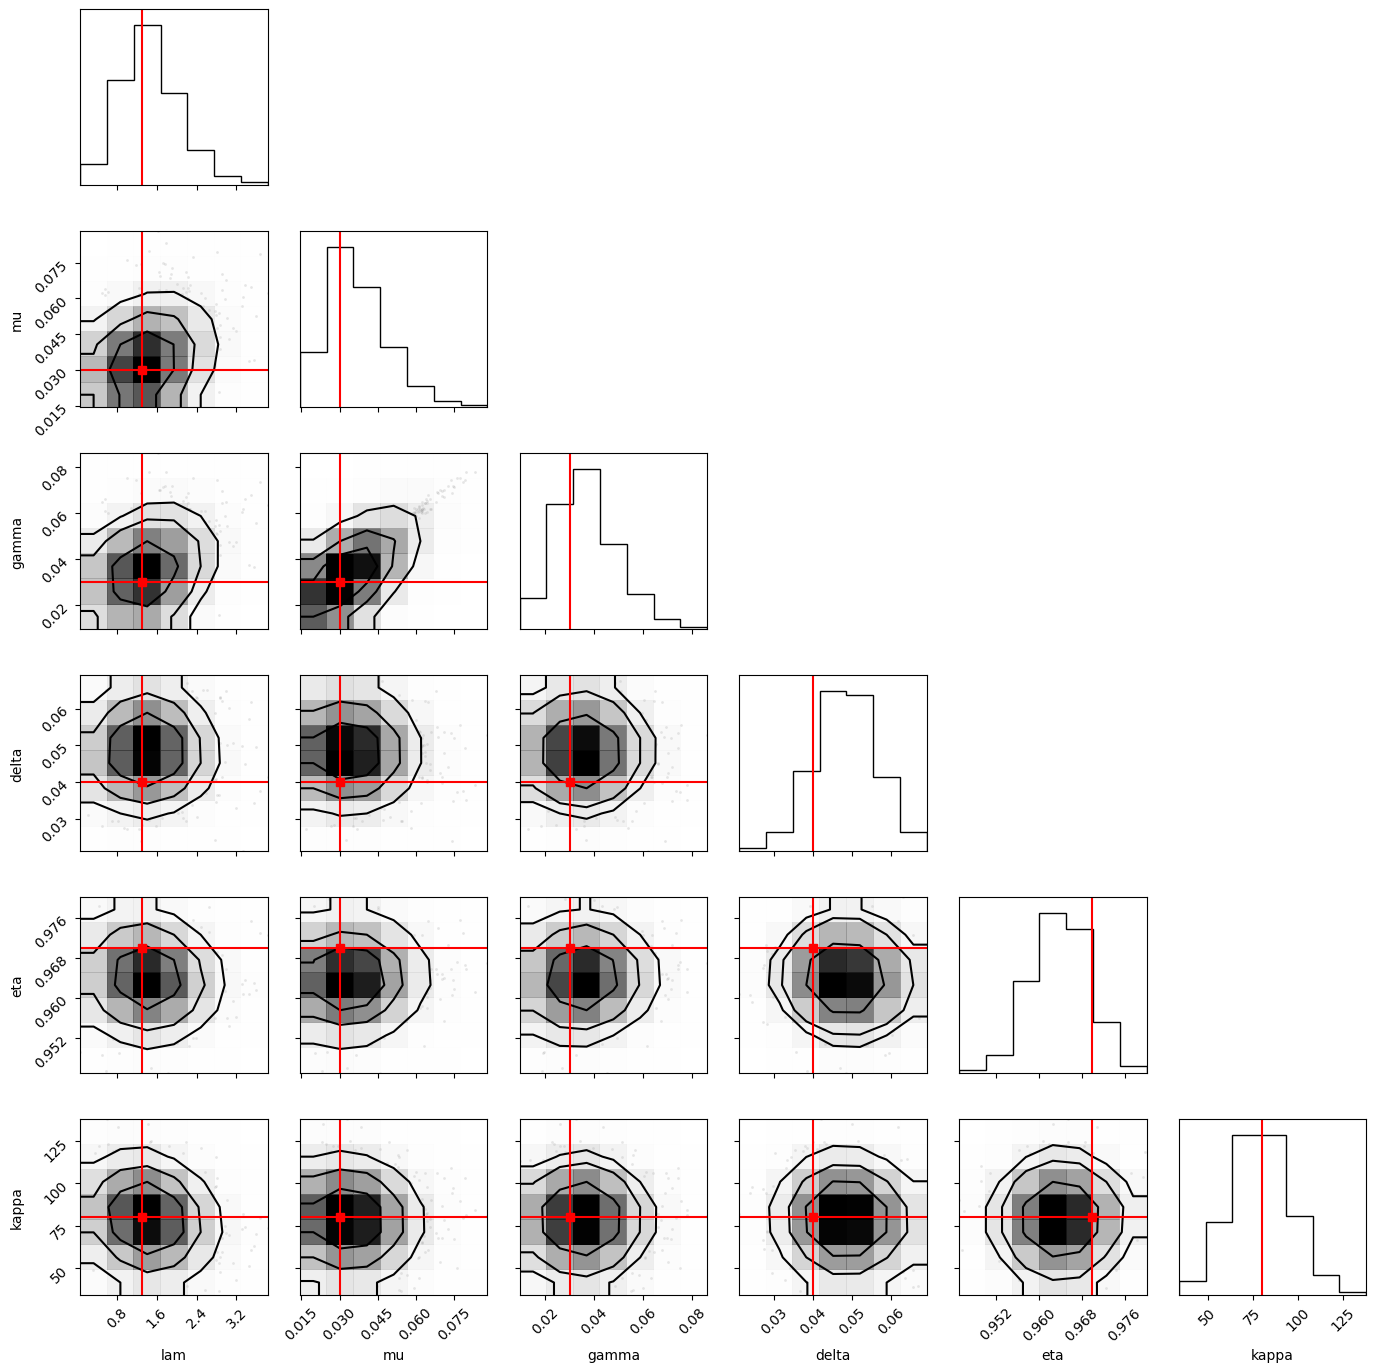

In [15]:
posterior_samples = posterior.sample((1000,), x=y)
df = pd.DataFrame(posterior_samples, columns = params_true.index)

prior_samples = prior.sample((1000,))

# Visualise the univariate and pairwise marginals
figure = corner.corner(df.values, bins=7, smooth=1, labels=df.columns)
corner.overplot_lines(figure, params_true.values, color="r")
corner.overplot_points(figure, params_true.values[None], marker = 's',
                       color="r")
plt.tight_layout()

It's sometimes helpful to compare the univariate marginals of the posterior with the initial prior, to compare how much the model has learnt from the data.

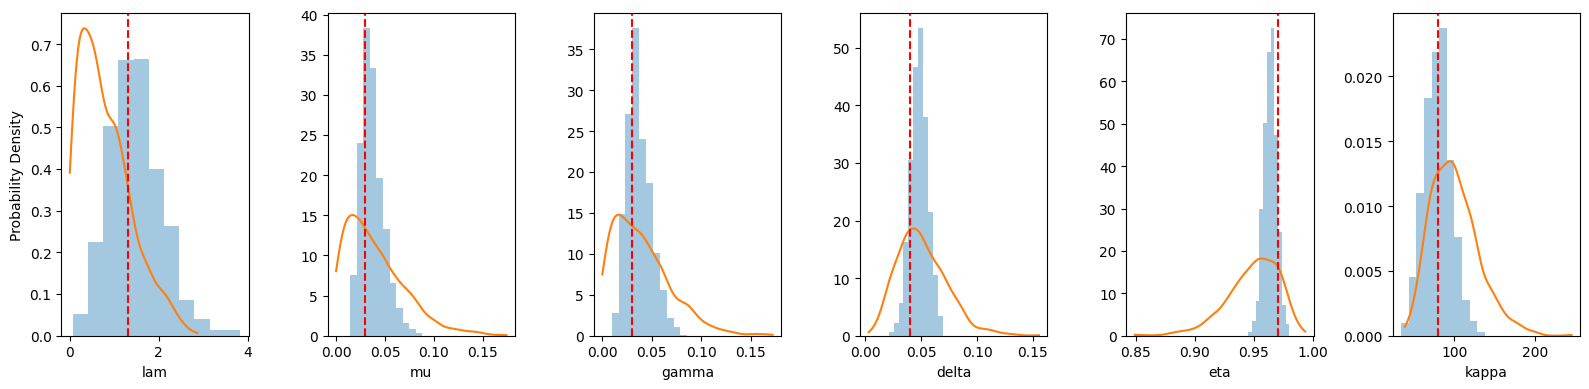

In [16]:
ndims = df.shape[1]

fig, axes = plt.subplots(1, ndims, figsize = (16, 4))
for i, var in enumerate(df.columns):
    axes[i].hist(df.values[:, i], bins=11, alpha=0.4, density=True)
    sns.kdeplot(prior_samples[:, i], ax = axes[i], cut = 0)
    axes[i].axvline(x=params_true[var], linestyle = '--',
                    color = 'red')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('')
axes[0].set_ylabel('Probability Density')
plt.tight_layout()

It's also often useful to compare the observed data to simulations drawn from the posterior (often called the posterior predictive checks)

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

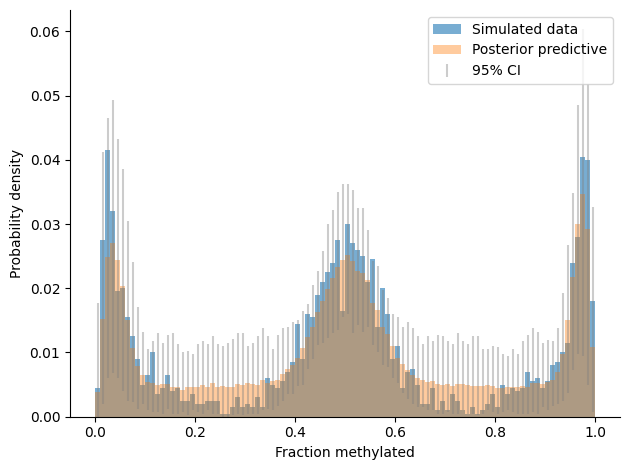

In [17]:
# Let's generate simulations for the first 100 points in the posterior
y_hat = simulation_wrapper(posterior_samples[:100, :])
y_hat_mean = y_hat.mean(axis = 0)

# Calculate the posterior predictive mean and 95% CI
lower_err = y_hat.mean(axis = 0) - y_hat.quantile(0.025, axis = 0)
upper_err = y_hat.quantile(0.975, axis = 0) - y_hat.mean(axis = 0)
yhat_err = np.stack([lower_err, upper_err])

fig, ax = plt.subplots()
plt.bar(bin_centres, y[0, :], width=0.01, alpha = 0.6)
plt.bar(bin_centres, y_hat_mean, width=0.01, alpha = 0.4)
plt.errorbar(bin_centres, y_hat_mean, yerr = yhat_err, fmt = 'none',
             alpha = 0.4, color = 'gray')
plt.legend(['Simulated data', 'Posterior predictive', '95% CI'])
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

Those results are certainly encouraging, with just 1000 simulations the NN has been able to well identify some of the parameters, and identify a region of parameter space which produces simulations which "look like" the observed data. But how much of the parameter uncertainty is driven by a lack of simulations, rather than the inherent uncertainty in the posterior?
To check whether the inference algorithm is well calibrated (e.g. the model is neither over or underconfident), we can perform simulation based calibration (SBC). This amounts to drawing parameter sets from the prior, calculating the posterior for each of these points and then calculating how often the posterior samples fall below the true parameter values. Note that in traditional inference this would be a very time consuming process, but because the NPE inference is amortised this can be done straightforwardly!

In [18]:
from sbi.analysis.plot import sbc_rank_plot
from sbi.diagnostics import check_sbc, check_tarp, run_sbc, run_tarp

num_sbc_samples = 200  # choose a number of sbc runs, should be ~100s

# generate ground truth parameters and corresponding simulated observations for SBC.
thetas = prior.sample((num_sbc_samples,))
xs = simulation_wrapper(thetas)

# run SBC: for each inference we draw 1000 posterior samples.
num_posterior_samples = 1_000

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

Drawing 1000 samples for 200 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 SBC samples:   0%|          | 0/200 [00:00<?, ?it/s]

In [19]:
check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"""
)

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [2.1051621e-05 7.9117544e-02 4.4069829e-04 2.2565813e-01 1.3716702e-01
 2.6823327e-01]


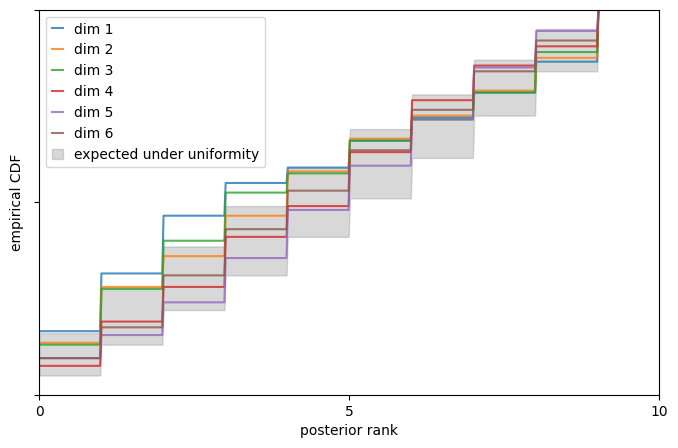

In [20]:
f, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf")

 When I trained a NN with only 1000 simulations, the inference was not well calibrated for all parameters...

So let's retrain the network with significantly more simulations! To save time, I've pregenerated a larger batch of simlulations (~100K) and trained a second NN on this data, which took about 2 hours on my MacBook. Let's see how good this network is compared to the one trained on a small batch of data.

In [21]:
!wget "https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/1-flipflop_inference.pkl"

--2025-12-22 21:48:38--  https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/1-flipflop_inference.pkl
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/1-flipflop_inference.pkl [following]
--2025-12-22 21:48:39--  https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/1-flipflop_inference.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50191451 (48M) [application/octet-stream]
Saving to: ‘1-flipflop_inference.pkl’

1-flipflop_inferenc 100%[===================>]  47.87M  73.1MB/s    in 0.7s    

2025-12-22 21:48:42 (7

In [22]:
with open("1-flipflop_inference.pkl", "rb") as f:
    inference_big = pickle.load(f)

posterior_big = inference_big.build_posterior()

  0%|          | 0/1000 [00:00<?, ?it/s]

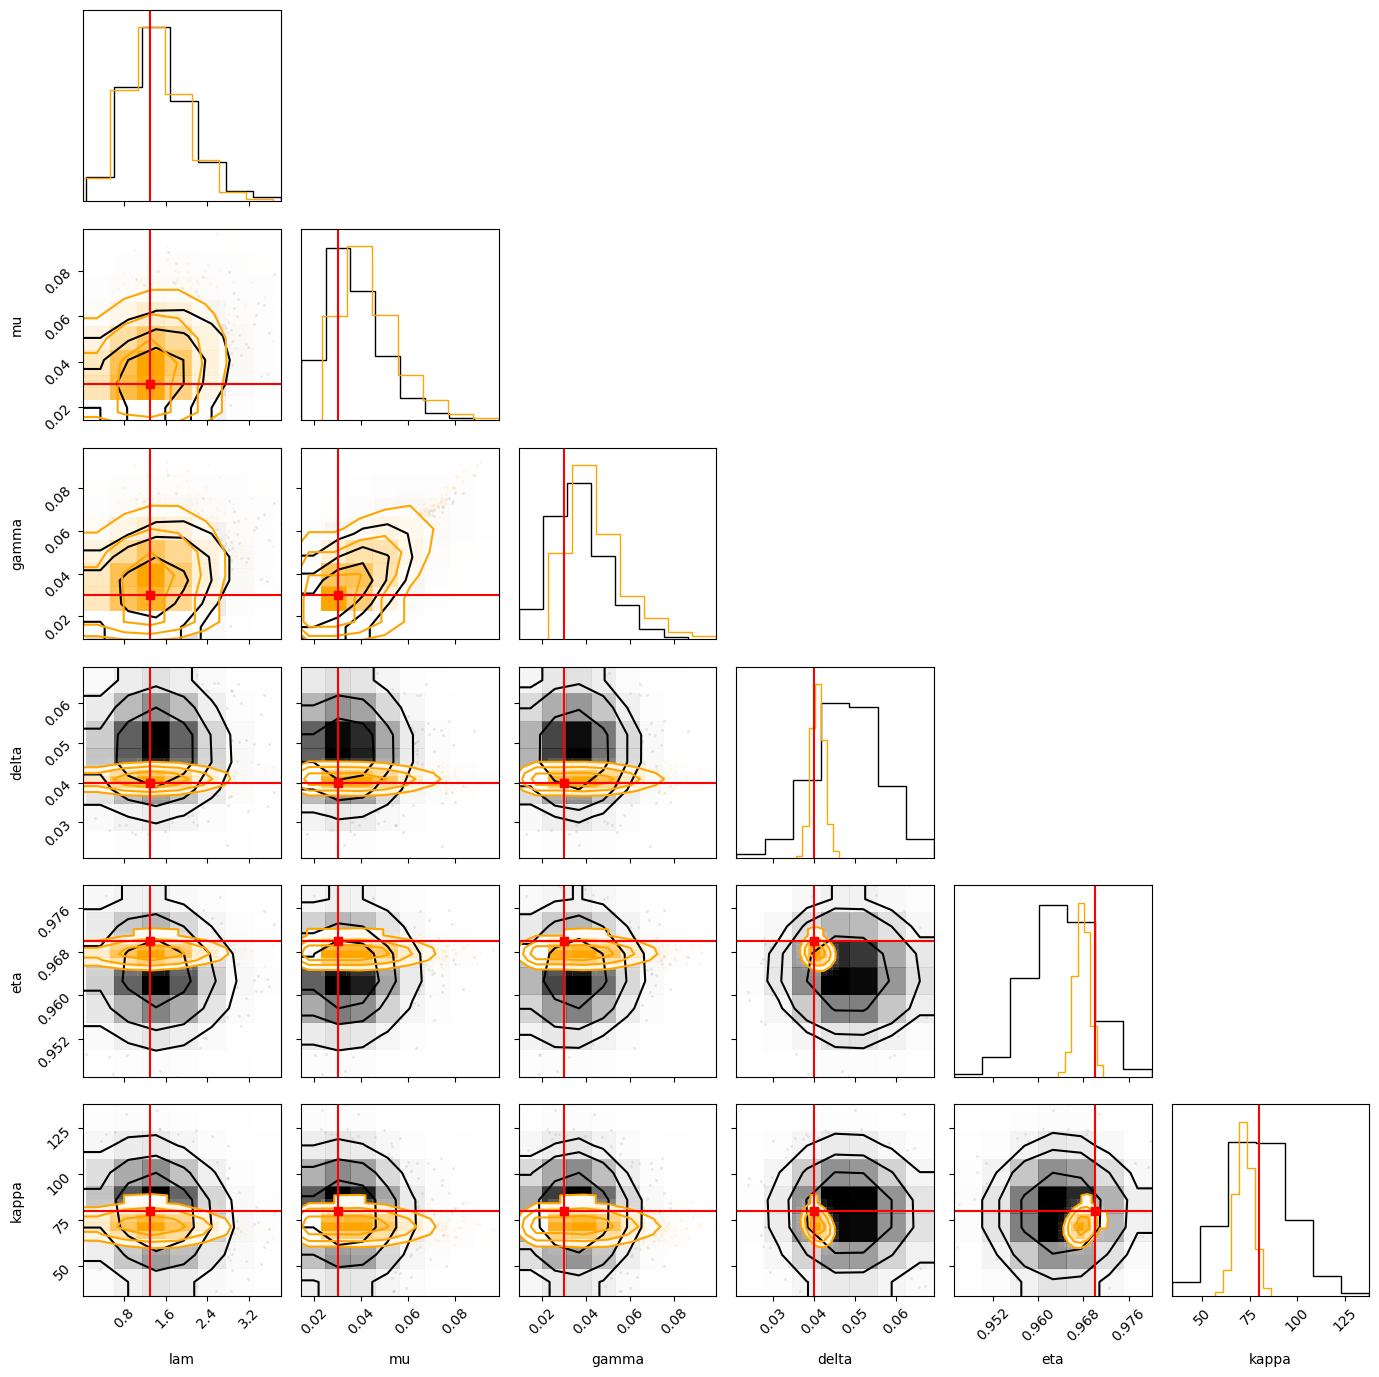

In [23]:
posterior_samples_big = posterior_big.sample((1000,), x=y)
df_big = pd.DataFrame(posterior_samples_big, columns = params_true.index)

# Visualise the univariate and pairwise marginals
figure = corner.corner(df.values, bins=7, smooth=1, labels=df.columns,
                       colour = 'blue')
corner.corner(df_big.values, bins=7, smooth=1, labels=df.columns,
              fig = figure, color = 'orange')
corner.overplot_lines(figure, params_true.values, color="r")
corner.overplot_points(figure, params_true.values[None], marker = 's',
                       color="r")
plt.tight_layout()

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

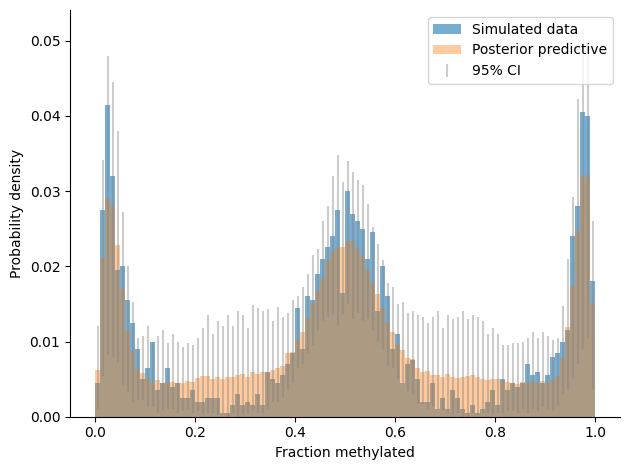

In [24]:
# Let's generate simulations for the first 100 points in the posterior
y_hat_big = simulation_wrapper(posterior_samples_big[:100, :])
y_hat_big_mean = y_hat_big.mean(axis = 0)

# Calculate the posterior predictive mean and 95% CI
lower_err_big = y_hat_big_mean - y_hat_big.quantile(0.025, axis = 0)
upper_err_big = y_hat_big.quantile(0.975, axis = 0) - y_hat_big_mean
yhat_err_big = np.stack([lower_err_big, upper_err_big])

fig, ax = plt.subplots()
plt.bar(bin_centres, y[0, :], width=0.01, alpha = 0.6)
plt.bar(bin_centres, y_hat_big_mean, width=0.01, alpha = 0.4)
plt.errorbar(bin_centres, y_hat_big_mean, yerr = yhat_err_big, fmt = 'none',
             alpha = 0.4, color = 'gray')
plt.legend(['Simulated data', 'Posterior predictive', '95% CI'])
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

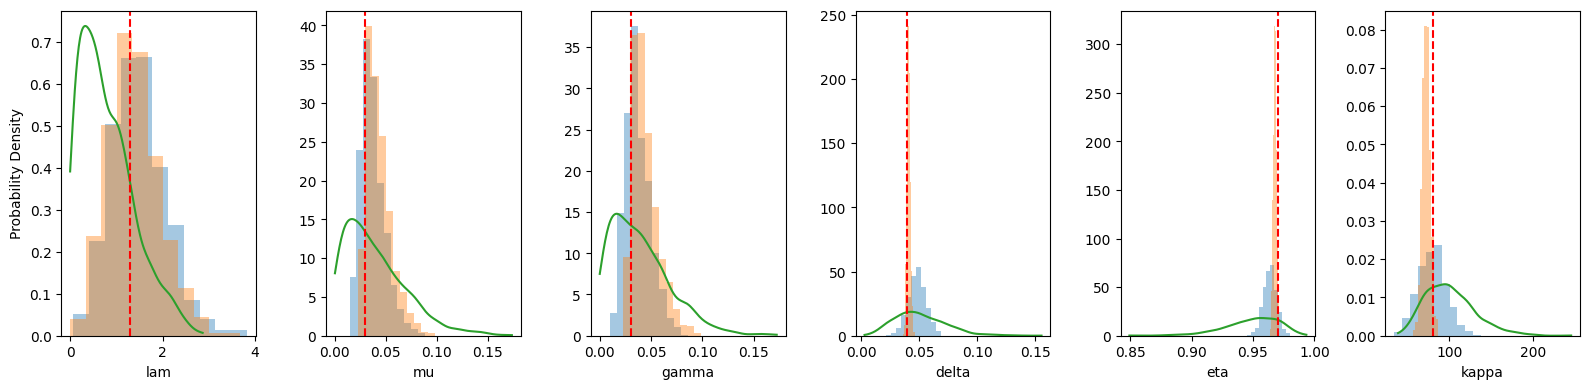

In [25]:
fig, axes = plt.subplots(1, ndims, figsize = (16, 4))
for i, var in enumerate(df.columns):
    axes[i].hist(df.values[:, i], bins=11, alpha=0.4, density=True)
    axes[i].hist(df_big.values[:, i], bins=11, alpha=0.4, density=True)
    sns.kdeplot(prior_samples[:, i], ax = axes[i], cut = 0)
    axes[i].axvline(x=params_true[var], linestyle = '--',
                    color = 'red')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('')
axes[0].set_ylabel('Probability Density')
plt.tight_layout()

So training on a significantly larger number of samples has improved the ability of the NN to recover the ground truth parameter values, especially for the harder to estimate lam and kappa parameters!

/usr/local/lib/python3.12/dist-packages/sbi/utils/diagnostics_utils.py:45: UserWarning: Capping max_sampling_batch_size from 10000 to 500 to avoid excessive memory usage.
  posterior_samples = posterior.sample_batched(


Drawing 1000 samples for 200 observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Calculating ranks for 200 SBC samples:   0%|          | 0/200 [00:00<?, ?it/s]

kolmogorov-smirnov p-values 

    check_stats['ks_pvals'] = [0.37009487 0.10485407 0.02252806 0.35156205 0.02252806 0.00842076]
c2st accuracies 
check_stats['c2st_ranks'] = [0.4825 0.4925 0.4975 0.5325 0.5325 0.5125]


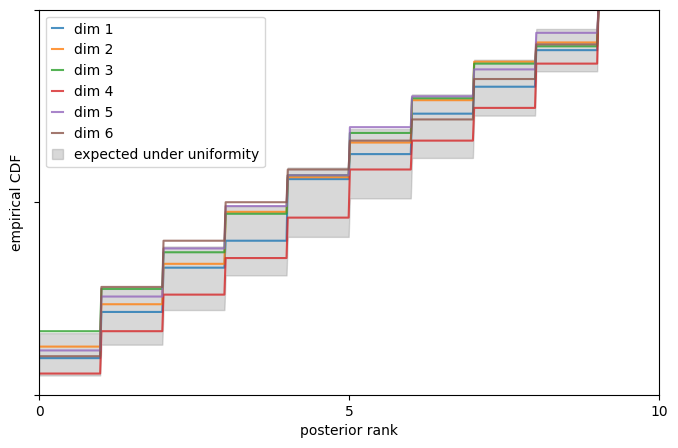

In [26]:
ranks_big, dap_samples_big = run_sbc(
    thetas, xs, posterior_big, num_posterior_samples=num_posterior_samples
)

check_stats_big = check_sbc(
    ranks_big, thetas, dap_samples_big, num_posterior_samples=num_posterior_samples
)

print(
    f"""kolmogorov-smirnov p-values \n
    check_stats['ks_pvals'] = {check_stats_big['ks_pvals'].numpy()}"""
)

print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats_big['c2st_ranks'].numpy()}"
)

f, ax = sbc_rank_plot(ranks_big, 1_000, plot_type="cdf")

So increasing the number of simulations by 2 orders of magnitude definitely improved the NPE inference's calibration. Your results may vary, but I found that there was still some miscalibration of the kappa parameter, so a reasonable next step may be to retrain with even more simulations, which may require a HPC rather than a desktop computer. What other approaches could improve the ability of the network to learn the mapping between parameters and simulated data?

# Optional extra
Above, we simplified the problem by fixing the number of stem cells and the age of the patient. However, the number of stem cells is an important biological parameter to try and infer, and the age of the patient is obviously something we'd like to give the model separately at runtime. Here, we will generalise the model to include `S` and `age` as free parameters. For `S`, this can be done using categorical distributions and we will assume that `S` is an integer between 3 and 10. For `age`, we will restrict to between 0 and 50 years old for the sake of efficiency (although in a final run, we'd want to extend this across the entire biologically plausible range). We will then use conditional density estimators to learn the posterior for a given value of `age`.

In [27]:
import torch
from torch.distributions import Distribution, Categorical, constraints

class ShiftedCategorical(Distribution):
    """
    Discrete distribution over {shift, shift+1, ..., shift+K-1}
    implemented as Categorical over {0,...,K-1} plus an integer shift.

    Avoids TransformedDistribution, which sbi may fail to reconstruct on `.to(device)`.
    """
    arg_constraints = {"probs": constraints.simplex}
    support = constraints.real   # keep it generic / version-robust
    has_enumerate_support = True

    def __init__(self, probs: torch.Tensor, shift: int = 0, validate_args=None):
        self.probs = probs
        self.shift = int(shift)
        self.base = Categorical(probs=self.probs)
        super().__init__(
            batch_shape=self.base.batch_shape,
            event_shape=torch.Size(),
            validate_args=validate_args,
        )

    def sample(self, sample_shape=torch.Size()):
        s_raw = self.base.sample(sample_shape)  # int in {0..K-1}
        return s_raw + self.shift               # int in {shift..shift+K-1}

    def log_prob(self, value):
        # Accept either float or int inputs by casting to long after shifting
        v = (value - self.shift).to(dtype=torch.long)
        return self.base.log_prob(v)

    def enumerate_support(self, expand=True):
        return self.base.enumerate_support(expand=expand) + self.shift

    def to(self, device):
        return ShiftedCategorical(self.probs.to(device), shift=self.shift, validate_args=self._validate_args)


In [28]:
def prior_func_general():
    # Define independent prior for parameters [lam, mu, gamma,
    #            delta, eta, kappa]
    kappamean, kappastd = lognormal_convert_params(100, 30)

    S_probs = torch.ones(1, 8) * 1/8

    prior = MultipleIndependent(
        [
            ShiftedCategorical(probs=S_probs, shift=3),  # S in {3..10}
            HalfNormal(torch.tensor([1.0])),
            HalfNormal(torch.tensor([0.05])),
            HalfNormal(torch.tensor([0.05])),
            Beta(torch.tensor([5.0]), torch.tensor([95.0])),
            Beta(torch.tensor([95.0]), torch.tensor([5.0])),
            LogNormal(torch.tensor([kappamean]), torch.tensor([kappastd])),
            Uniform(torch.tensor([0.0]), torch.tensor([50.0]))
        ],
        validate_args=False,
    )

    return prior

def generate_data_wrapper_general(params):
    S, lam, mu, gamma, delta, eta, kappa, age = params
    return generate_data(int(S), lam, mu, gamma, delta, eta, kappa, age, N)

def simulation_wrapper_general(params):
    """
    Returns summary statistics from input paramaters in `params`.

    Summarizes the output of the simulator and converts it to `torch.Tensor`.
    """
    # print(params)
    obs = generate_data_wrapper_general(params)
    summstats = torch.as_tensor(calculate_summary_statistics(obs))

    return summstats

# Check prior, return PyTorch prior.
prior_general, num_parameters_general, prior_returns_numpy_general = process_prior(prior_func_general())

# Check simulator, returns PyTorch simulator able to simulate batches.
simulation_wrapper_general = process_simulator(simulation_wrapper_general, prior_general, prior_returns_numpy_general)

# Consistency check after making ready for sbi.
check_sbi_inputs(simulation_wrapper_general, prior_general)


/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

As above, let's simulate some synthetic data, this time using the more general simulator function.

/tmp/ipython-input-2894701464.py:95: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:103: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-input-2894701464.py:129: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_on = mu / (gamma+mu) + (1 - mu/(gamma+mu))*np.exp(-(mu+gamma)*twait)
/tmp/ipython-input-2894701464.py:136: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  p_given_off = mu / (gamma+mu) * (1 - np.exp(-(mu+gamma)*twait))
/tmp/ipython-in

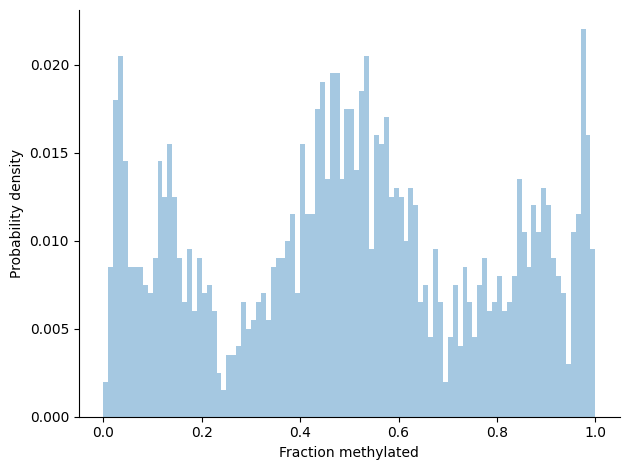

In [29]:
params_true_general = pd.Series({
    'S':5,
    'lam' : 1.3,
    'mu' : 0.03,
    'gamma' : 0.03,
    'delta' : 0.04,
    'eta' : 0.97,
    'kappa' : 80,
    'age':30.0
})

y_general = simulation_wrapper_general(params_true_general.to_numpy().reshape(1, -1))

fig, ax = plt.subplots()
plt.bar(bin_centres, y_general[0, :],
        width=0.01, alpha = 0.4,
        )
plt.xlabel('Fraction methylated')
plt.ylabel('Probability density')
sns.despine()
plt.tight_layout()

In [30]:
!wget "https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/2-flipflop_general_inference.pkl"

--2025-12-22 21:49:26--  https://github.com/CalumGabbutt/IX-tutorial-CG-SBI/raw/main/data/2-flipflop_general_inference.pkl
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/2-flipflop_general_inference.pkl [following]
--2025-12-22 21:49:26--  https://raw.githubusercontent.com/CalumGabbutt/IX-tutorial-CG-SBI/main/data/2-flipflop_general_inference.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46635090 (44M) [application/octet-stream]
Saving to: ‘2-flipflop_general_inference.pkl’

2-flipflop_general_ 100%[===================>]  44.47M  75.5MB/s    in 

In [31]:
with open("2-flipflop_general_inference.pkl", "rb") as f:
    inference_general = pickle.load(f)

density_general_estimator = inference_general._neural_net

In [32]:
potential_fn, theta_transform = posterior_estimator_based_potential(
    density_general_estimator, prior=prior_general, x_o=y_general
)

conditioned_potential_fn, restricted_tf, conditional_prior = conditional_potential(
    potential_fn=potential_fn,
    theta_transform=theta_transform,
    prior=prior_general,
    condition=torch.as_tensor(
        [dim for dim in range(num_parameters_general-1)] + [float(params_true_general['age'])]
    ),  # the first free paramaters and are ignored internally
    dims_to_sample=[dim for dim in range(num_parameters_general-1)],
)

mcmc_posterior = MCMCPosterior(
    potential_fn=conditioned_potential_fn,
    theta_transform=restricted_tf,
    proposal=conditional_prior,
    method="slice_np_vectorized",
    num_chains=20,
).set_default_x(y_general)
cond_samples = mcmc_posterior.sample((100,))

/usr/local/lib/python3.12/dist-packages/sbi/inference/posteriors/mcmc_posterior.py:126: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

We now have a set of samples from the amortised posterior condtioned on the patient's age being equal to the true value. Let's plot this conditioned posterior.

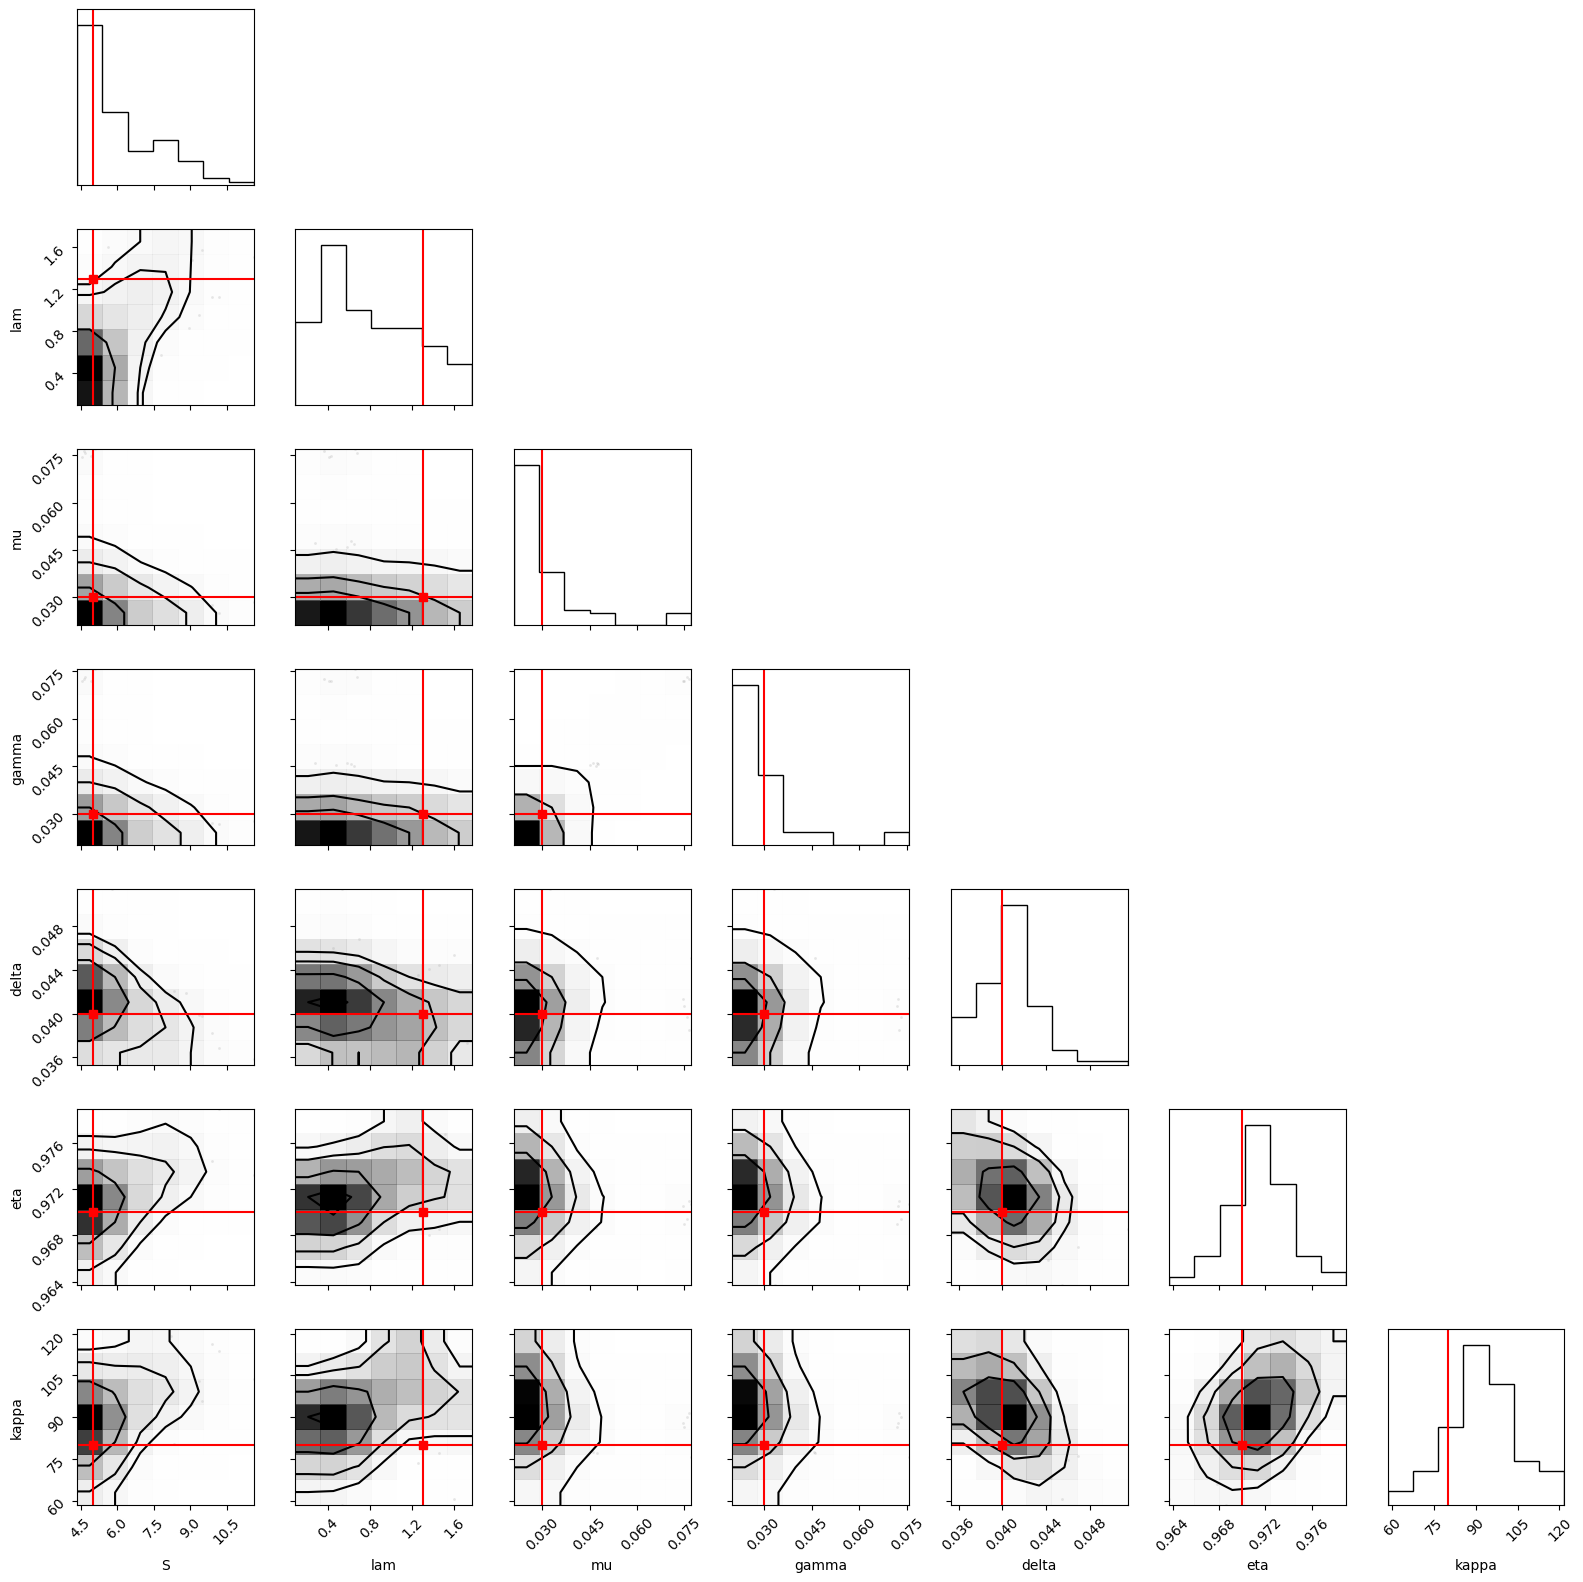

In [33]:
params_true_sub = params_true_general.iloc[:-1]
df_general = pd.DataFrame(cond_samples, columns = params_true_sub.index)

# Visualise the univariate and pairwise marginals
figure = corner.corner(df_general.values, bins=7, smooth=1, labels=df_general.columns)
corner.overplot_lines(figure, params_true_sub.values, color="r")
corner.overplot_points(figure, params_true_sub.values[None], marker = 's',
                       color="r")
plt.tight_layout()

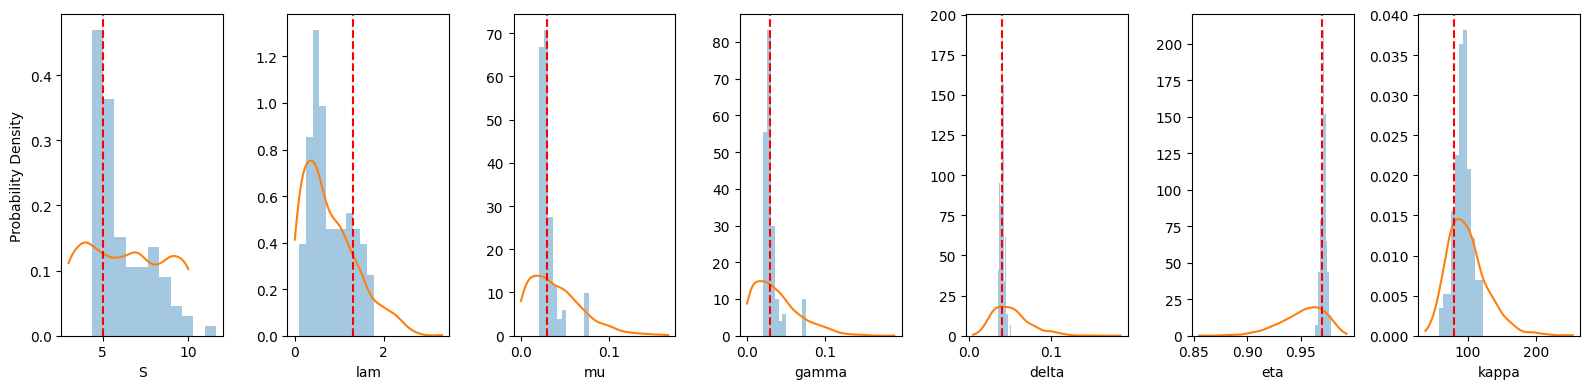

In [34]:
ndims_sub = df_general.shape[1]

prior_samples_sub = prior_general.sample((1000,))

fig, axes = plt.subplots(1, ndims_sub, figsize = (16, 4))
for i, var in enumerate(df_general.columns):
    axes[i].hist(df_general.values[:, i], bins=11, alpha=0.4, density=True)
    sns.kdeplot(prior_samples_sub[:, i], ax = axes[i], cut = 0)
    axes[i].axvline(x=params_true_sub[var], linestyle = '--',
                    color = 'red')
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('')
axes[0].set_ylabel('Probability Density')
plt.tight_layout()

How does this posterior compare to the previous large run (both used 100K simulations)? Why do you think this is?